<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/coco2017_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model comparison on COCO 2017 dataset
*   SSD300 VGG16
*   Faster R-CNN ResNet-50 FPN
*   Mask R-CNN ResNet-50 FPN
*   YOLOv5s
*   YOLOv5m






### Get requirements

In [ ]:
%%shell

# Install Yolov5
cd /content
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install --quiet -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 8969, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8969 (delta 0), reused 1 (delta 0), pack-reused 8963
Receiving objects: 100% (8969/8969), 9.43 MiB | 31.77 MiB/s, done.
Resolving deltas: 100% (6244/6244), done.
     |████████████████████████████████| 636 kB 8.8 MB/s 


In [ ]:
%%shell

# Clone asset files
cd /content
git clone https://github.com/joangog/object-detection-assets
cd object-detection-assets
mv assets ../
rm -rf /content/object-detection-assets/

Cloning into 'object-detection-assets'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 2), reused 11 (delta 2), pack-reused 0
Unpacking objects: 100% (14/14), done.


### Import packages

In [ ]:
# Import packages

import os
from google.colab import files

import math
import sys
import time
import numpy as np
import json
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

import assets.utils as AU
import assets.transforms as AT
import assets.coco_utils as ACU
from assets.coco_eval import CocoEvaluator

### Define aux functions

In [ ]:
# Copied and adjusted from repo pytorch/vision/references/detection/engine.py
def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, M.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, M.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


# Copied and adjusted from repo pytorch/vision/references/detection/engine.py
@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = AU.MetricLogger(delimiter="  ")
    header = 'Test:'
    coco = ACU.get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        # test lines #######################

        # label_ids = dataset.coco.getCatIds()
        # label_info = dataset.coco.loadCats(label_ids)
        # label_names = [label['name'] for label in label_info]
        # labels = dict(zip(label_ids,label_names))

        # img = F.convert_image_dtype(images[1],torch.uint8).cpu()
        
        # true_bboxes = F.Tensor([obj['bbox'] for obj in targets[1]]).cpu()
        # true_labels = [labels[obj['category_id']] for obj in targets[1]]
        # true_img = U.draw_bounding_boxes(img, true_bboxes, true_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(true_img))

        
        # output = outputs[1]
        # pred_bboxes = torch.stack([output['boxes'][i] for i in range(0,len(output['boxes'])) if output['scores'][i] > 0.5])
        # pred_labels_ids = output['labels'].tolist()
        # pred_label_ids = [pred_labels_ids[i] for i in range(0,len(pred_labels_ids)) if output['scores'][i] > 0.5]  
        # pred_labels = [labels[label_id] for label_id in pred_label_ids]
        # pred_img = U.draw_bounding_boxes(img, pred_bboxes, pred_labels)
        # plt.figure(figsize = (25,7))
        # plt.imshow(F.to_pil_image(pred_img))

        ###############
        
        res = {target[0]["image_id"]: output for target, output in zip(targets, outputs) if len(target)!=0}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)

    return coco_evaluator, outputs

def print_bbox():
  return 0

def format_bbox(image, target):  # formats bbox from (x,y,w,h) to (x,y,x,y)
  for obj in target:
    old_bbox = obj['bbox']
    obj['bbox'][2] = old_bbox[0] + old_bbox[2]
    obj['bbox'][3] = old_bbox[1] + old_bbox[3]
  return image, target


### Download COCO 2017 dataset

In [ ]:
%%shell

# Download images
cd /content
wget 'http://images.cocodataset.org/zips/val2017.zip'
unzip -q 'val2017.zip'
rm 'val2017.zip'

--2021-08-16 17:30:19--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.168.235
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.168.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  30.5MB/s    in 23s     

2021-08-16 17:30:42 (34.5 MB/s) - ‘val2017.zip’ saved [815585330/815585330]



In [ ]:
%%shell

# Download annotations
cd /content
wget 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
unzip -q 'annotations_trainval2017.zip'
rm 'annotations_trainval2017.zip'
cp '/content/annotations/instances_val2017.json' '/content/val2017'

--2021-08-16 17:30:47--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.82.204
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.82.204|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  44.5MB/s    in 5.9s    

2021-08-16 17:30:53 (41.1 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



### Load COCO 2017 dataset

In [ ]:
img_dir = '/content/val2017'
ann_file = os.path.join(img_dir,'instances_val2017.json')  # annotations

# Define data transforms
transforms = AT.Compose([AT.ToTensor()]) # Compose([Resize((640,640)), ToTensor()])

# Create dataset
dataset = CocoDetection(img_dir, ann_file, transforms = transforms)

# test
# for ann_id in dataset.coco.anns:
  # dataset.coco.anns[ann_id]['bbox'] = test_format_bbox(dataset.coco.anns[ann_id]['bbox'])

# Create data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=AU.collate_fn)

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


### Load pre-trained model

In [ ]:
%cd /content

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'SSD300 VGG16' # @param ['SSD300 VGG16', 'Faster R-CNN ResNet-50 FPN', 'Mask R-CNN ResNet-50 FPN', 'YOLOv5s', 'YOLOv5m']

if model_name == 'SSD300 VGG16':
  model_id = 'ssd'
  model = M.ssd300_vgg16(pretrained=True, progress=True)
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn'
  model = M.maskrcnn_resnet50_fpn(pretrained=True, progress=True)
elif model_name == 'YOLOv5s':
  model_id = 'yolov5s'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
elif model_name == 'YOLOv5m':
  model_id = 'yolov5m'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5m')

print('Loaded model: '+ model_name + '\n')


/content


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


  0%|          | 0.00/136M [00:00<?, ?B/s]

Loaded model: SSD300 VGG16



### Test model with image sample

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


NameError: ignored

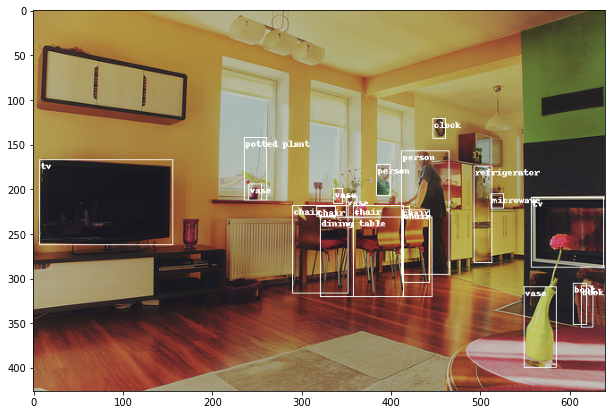

In [ ]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get image sample
img_id = 139 #11051 # 67406
img = F.convert_image_dtype(F.to_tensor(PIL.Image.open(os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name']))),torch.uint8)
img_formatted = torch.tensor(np.divide(img,255)).float().to(device)
img_anns = list(dataset.coco.loadAnns(dataset.coco.getAnnIds([img_id])))  # create a copy to avoid update to original annotations

# Generate model predictions
model.eval()
with torch.no_grad():
  pred = model([img_formatted])

# Get label names
label_ids = dataset.coco.getCatIds()
label_info = dataset.coco.loadCats(label_ids)
label_names = [label['name'] for label in label_info]
labels = dict(zip(label_ids,label_names))

# Get ground truth bboxes
true_bboxes = F.Tensor([obj['bbox'] for obj in img_anns]).to(device)
true_labels = [labels[obj['category_id']] for obj in img_anns]
true_img = U.draw_bounding_boxes(img, true_bboxes, true_labels)
plt.figure(figsize = (25,7))
plt.imshow(F.to_pil_image(true_img))

# Get ground truth segmentation masks
# print(img_anns)
# true_masks = F.Tensor([obj['segmentation'][0] for obj in img_anns])
# true_labels = [labels[obj['category_id']] for obj in img_anns]
# true_img = U.draw_segmentation_masks(img, true_masks, true_labels)
# plt.figure(figsize = (25,7))
# plt.imshow(F.to_pil_image(true_img))

# Get predicted bboxes
pred_bboxes = torch.stack([pred[0]['boxes'][i] for i in range(0,len(pred[0]['boxes'])) if pred[0]['scores'][i] > 0.5])
pred_labels_ids = pred[0]['labels'].tolist()
pred_label_ids = [pred_labels_ids[i] for i in range(0,len(pred_labels_ids)) if pred[0]['scores'][i] > 0.5]
pred_img = U.draw_bounding_boxes(img, pred_bboxes, pred_labels)
plt.figure(figsize = (25,7))
plt.imshow(F.to_pil_image(pred_img))



### Evaluate model

In [ ]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Evaluate model
evaluator, outputs = evaluate(model, data_loader, device)



Test:  [   0/2500]  eta: 0:20:44  model_time: 0.2953 (0.2953)  evaluator_time: 0.0318 (0.0318)  time: 0.4977  data: 0.1672  max mem: 238
Test:  [ 100/2500]  eta: 0:04:39  model_time: 0.0697 (0.0733)  evaluator_time: 0.0264 (0.0362)  time: 0.1076  data: 0.0032  max mem: 238
Test:  [ 200/2500]  eta: 0:04:22  model_time: 0.0694 (0.0714)  evaluator_time: 0.0264 (0.0366)  time: 0.1130  data: 0.0030  max mem: 239
Test:  [ 300/2500]  eta: 0:04:08  model_time: 0.0698 (0.0709)  evaluator_time: 0.0279 (0.0363)  time: 0.1123  data: 0.0031  max mem: 239
Test:  [ 400/2500]  eta: 0:03:57  model_time: 0.0690 (0.0712)  evaluator_time: 0.0282 (0.0363)  time: 0.1128  data: 0.0032  max mem: 239
Test:  [ 500/2500]  eta: 0:03:45  model_time: 0.0710 (0.0711)  evaluator_time: 0.0300 (0.0357)  time: 0.1103  data: 0.0028  max mem: 239
Test:  [ 600/2500]  eta: 0:03:33  model_time: 0.0690 (0.0709)  evaluator_time: 0.0281 (0.0358)  time: 0.1130  data: 0.0027  max mem: 239
Test:  [ 700/2500]  eta: 0:03:23  model_t

## Save results

In [ ]:
results = []
for i, img_id in enumerate(img_ids):  # For every image
  img_predictions = predictions[i]
  pred_boxes = img_predictions['boxes'].tolist()
  pred_labels = img_predictions['labels'].tolist()
  pred_scores = img_predictions['scores'].tolist()
  for j in range(0,len(pred_box)):  # For every predicted object
    pred_box = pred_boxes[j]
    results.append({
        'image_id': img_id,
        'category_id': pred_labels[j],
        'bbox': [round(val,1) for val in pred_box],  # Round for lower file size
        'score': pred_scores[j]
        })

results_file = os.path.join(img_dir,f'{model_id}_coco17_results.json')
with open(results_file, 'w') as outfile: 
    json.dump(results, outfile,indent = 2)



In [ ]:
files.download(results_file) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# results_dataset = dataset.loadRes(results_file)
# eval = cocoeval.COCOeval(dataset, results_dataset, iouType='bbox')
# eval.evaluate()
# eval.accumulate()
# eval.summarize()

